<img style="float: left;" src="../images/logo.png" width="400"/><img style="float: right;" src="../images/icons.png" width="400"/>

## Data availability

if you already run the case for portugal, the data are for this example are in `../edata/geff/201807_Sweden/`, otherwise see downloading instruction in [here](../2020Portugal/202007_Portugal_00_data_overview.ipynb)

## Event of interest: Sweden fires, 15-20 July 2018

### Background
In the summer of 2018, a large number of wildfires (primarily forest fires) occurred throughout much of Sweden. According to the Swedish Civil Contingencies Agency, they are the most serious in the country in modern history. The summer was unusually warm and dry, significantly raising the risk of fire. Firefighters from multiple countries were involved in fighting the fires. Many people were evacuated from their homes, but there were no fatalities.

Several of the fires were started by people using disposable barbecues, though bans on these were in place due to the weather conditions. Some were started by lightning strikes. Wildfires also occurred in the neighbouring countries Denmark, Finland and Norway, but no casualties due to wildfires were reported in Scandinavia.
(Source: https://en.wikipedia.org/wiki/2018_Sweden_wildfires).

### Active fires
Most of the active fires detected by the MODIS instruments occurred in central-west and north Sewden on 15/20 July.

In [2]:
# First of all, we need to import the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs

# Enable inline displaying of plots
%matplotlib inline

Let's download Fire Radiative Power from CAMS GFAS: see [https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-fire-emissions-gfas?tab=overview](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-fire-emissions-gfas?tab=overview)

this time the FRP data were not downloaded, you need to retreive them from the link above, place them in the right foder `./eodata/geff/global/frp/`, and rename it according to the file path used below.


In [6]:
# Where did the fire actually occur?
bbox = [10.1, 24.8, 55, 69]
lon_slice = slice(10.1, 24.8)
lat_slice = slice(69, 55)

# frp_20180701-31.nc is the gloabl FRP data available from CAMS GFAS: https://apps.ecmwf.int/datasets/data/cams-gfas/

# Open fire radiative power dataset
ds = xr.open_dataset("../eodata/geff/global/frp/frp_20180701-31.nc")
# Data have global coverage and are bundled in monthly datacubes, we will need to slice in time and space
ds = ds.loc[
    dict(
        valid_time=slice("2018-07-15", "2018-07-22"), longitude=lon_slice, latitude=lat_slice
    )
]
ds = ds.rename({"valid_time": "time"})

frpfire = ds.frpfire
frpfire.values[frpfire.values <= 1.e-10] = np.nan

In [7]:
frpfire

<xarray.DataArray 'frpfire' (time: 8, latitude: 140, longitude: 147)> Size: 659kB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 64B 2018-07-15 2018-07-16 ... 2018-07-22
  * latitude   (latitude) float64 1kB 68.95 68.85 68.75 ... 55.25 55.15 55.05
  * longitude  (longitude) float64 1kB 10.15 10.25 10.35 ... 24.55 24.65 24.75
Attributes: (12/33)
    GRIB_paramId:                             210099
    GRIB_dataType:                            ga
    GRIB_numberOfPoints:                      6480000
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    ...                                       ...
    GRIB_units:                               W m**-2
    long_name:                                Wildfire radiative power
    units:                                    W m**-2
    standard_name:                            unknown
    GRIB_number:                              0
    GRIB_surface:                             0.0

/tmp/ipykernel_3545723/1820059312.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


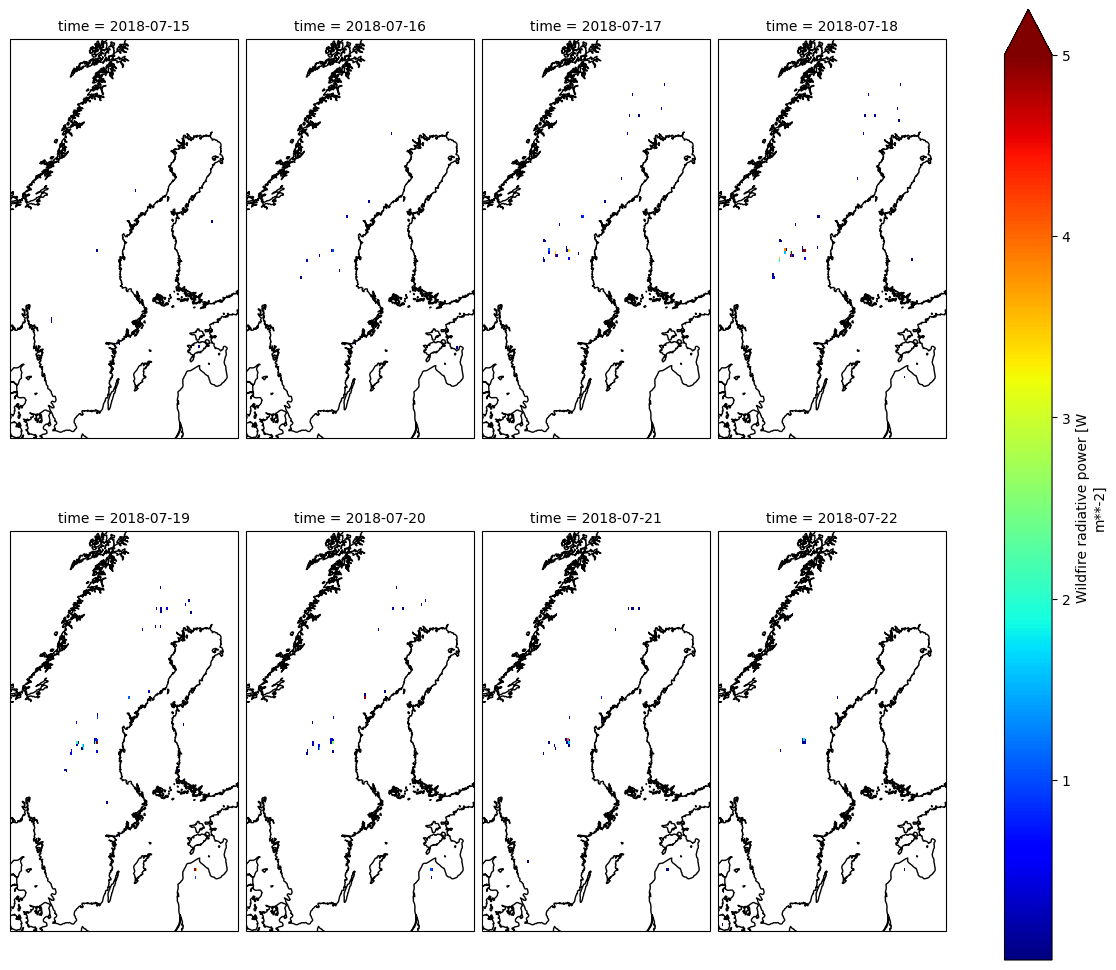

In [12]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=17.45, central_latitude=62)

p = frpfire.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    col="time",
    col_wrap=4,  # multiplot settings
    figsize=(12, 10),
    cmap=mpl.cm.jet,
    vmax=5,
    subplot_kws={"projection": map_proj},
)  # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

## store location of frp pixel

In [13]:
#store frp pixel location for the 6 days beetween the 15 and the 20 of July
x = []
y = []
for id in range(len(frpfire)):
    frpfire_ = frpfire.isel(time=id)
    idx = np.where(frpfire_>0)
    x.append(frpfire_.coords['longitude'][idx[1]]) # location of hot spot for the 15/07
    y.append(frpfire_.coords['latitude'][idx[0]])

## Explore the data

#### HRES forecast

This dataset provides real-time high-resolution deterministic (~9 Km) fire danger forecasts up to 10 days ahead. Let us explore the content of the sample file.

In [14]:
# Open the dataset
ds_rt_hr = xr.open_dataset("../eodata/geff/201807Sweden/rt_hr/ECMWF_FWI_20180715_1200_hr_fwi_rt.nc")


This dataset has three dimensions: latitude, longitude and time. In the lat/long plane data are distributed on a regular grid (2560 x 5120), while the time dimension is made of 10 levels (each corresponds to a daily forecast estimate). Each cell of this datacube contains only 8 variables: fwi, ffmc, dmc, dc, isi, bui, dsr, danger_risk. 

To plot and run basic operations, it is convenient to convert the dataset to a dataarray by extracting 1 variable, e.g. fwi. 

Remember: 
- DataArray = single multi-dimensional variable and its coordinates
- Dataset = holds multiple variables that potentially share the same coordinates.

In [15]:
# Convert ds to a dataarray extracting only the variable fwi
da_rt_hr = ds_rt_hr.fwi

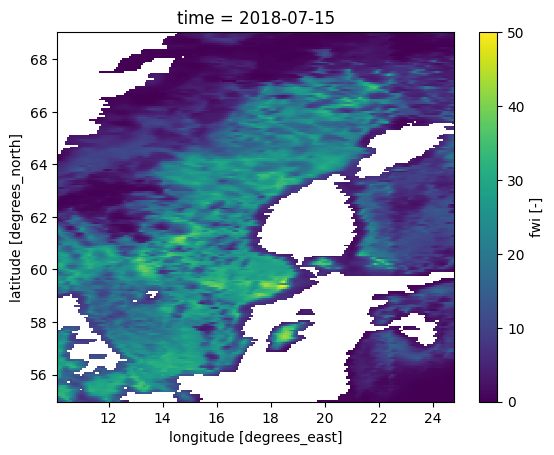

In [16]:
# Plot the first day
da_rt_hr[0].plot()

In [17]:
# Crop over area of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
# data were already cropped, we kept the line of code here anyway

fwi_rt_hr = da_rt_hr.loc[dict(lat=lat_slice, lon=lon_slice)]

/tmp/ipykernel_3545723/1634688689.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


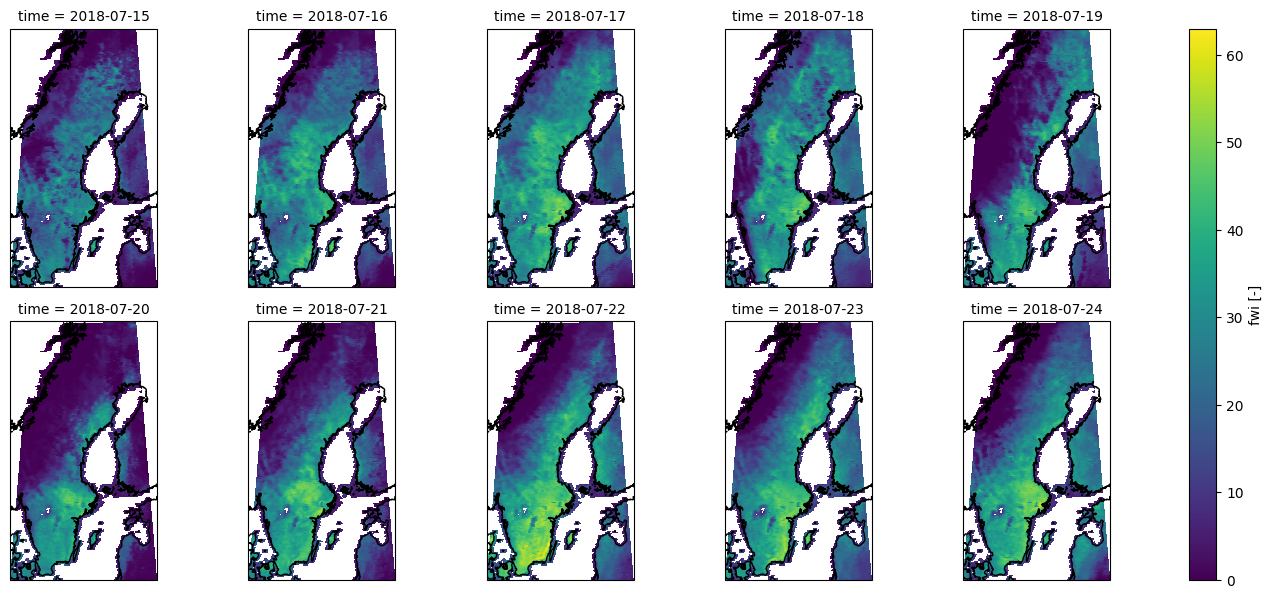

In [18]:
# Plot RT-HR
p = fwi_rt_hr.plot(
    transform=ccrs.PlateCarree(),
    col="time",
    col_wrap=5,
    subplot_kws={"projection": map_proj},
)
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

### geff-re: ERA5 based reanalysis of the Fire Weather Index

This dataset provides historical records of global fire danger conditions from 1980 to the present day and it is made of two main types of products: (i) deterministic model outputs (HRES reanalysis), (ii) probabilistic model outputs (made of 10 ensemble members, ENS reanalysis). It is updated as soon as new ERA5 data becomes available (~2 months behind real-time). 

Here we only consider the deterministic model output.

A single reanalysis layer is often used as proxy for observations (e.g. for validating the forecasts). Stacking together consecutive reanalysis estimates, allows to compute temporal trends and other long term statistics.

#### HRES reanalysis

Let's repeat the same operations shown above, this time the dataset has only 1 temporal layer.
The regular grid is smaller (640 x 1280) compared to the HRES/ENS forecasts.

The example below shows how to explore the single layer reanalysis. Examples of how to use a reanalysis datacube will be shown in follow-up tutorials.

In [19]:
# Open the dataset
ds_e5_hr = xr.open_dataset(
    "../eodata/geff/201807Sweden/e5_hr/ECMWF_FWI_20180715_1200_hr_fwi_e5.nc"
)

In [20]:
# Convert ds to a dataarray extracting only the variable fwi
da_e5_hr = ds_e5_hr.fwi
fwi_e5_hr = da_e5_hr.loc[dict(lat=lat_slice, lon=lon_slice)]


In [21]:
len(x)

8

/tmp/ipykernel_3545723/3824377233.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for iax, ax in enumerate(p.axes.flat):


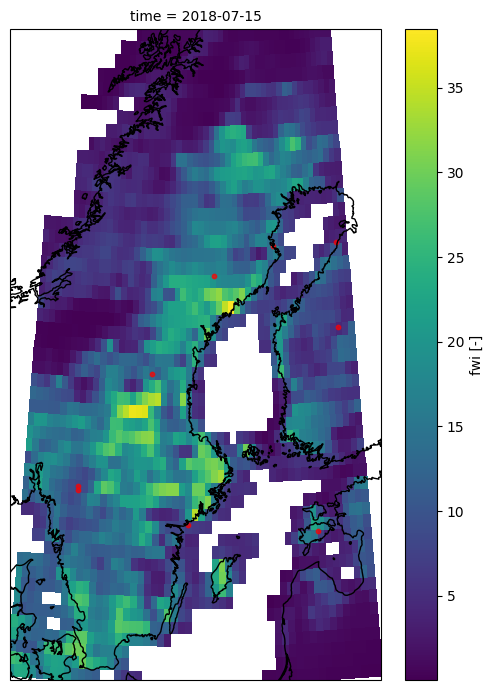

In [22]:
p = fwi_e5_hr.plot(
    transform=ccrs.PlateCarree(),
    col="time",
    col_wrap=1,
    figsize=(5,7),
    subplot_kws={"projection": map_proj},
)


for iax, ax in enumerate(p.axes.flat):
    ax.scatter(x[iax], y[iax], transform=ccrs.PlateCarree(), color='r', s=10, alpha=.7)
    ax.coastlines()
    ax.set_extent(bbox)

are all frp hotspot matching FWI high value?

why?

what could we check to explain the hotspot that are not located in high FWI value?